# Visualizations of the memory performance

In [22]:
import pandas as pd

def uses_rcl(data_structure: str) -> bool:
    """Return True if the data structure uses RCL, False otherwise
    
    Parameters
    ----------
    data_structure : str
        The name of the data structure
    
    Implementation details
    ----------------------
    The data structure uses RCL if it contains the substring "RCL" in its name.
    """
    return "RCL" in data_structure

def is_parallel(data_structure: str) -> bool:
    """Return True if the data structure is parallel, False otherwise
    
    Parameters
    ----------
    data_structure : str
        The name of the data structure
    
    Implementation details
    ----------------------
    The data structure is parallel if it contains the substring "PAR" in its name.
    """
    return "PAR" in data_structure

def get_data_structure_name(data_structure: str) -> str:
    """Return the name of the data structure
    
    Parameters
    ----------
    data_structure : str
        The name of the data structure
    
    Implementation details
    ----------------------
    The name of the data structure is the first word in the string.
    """
    if "BITVEC" in data_structure:
        return "BitVec"

    if "VEC" in data_structure:
        return "Vec"

    if "WEBGRAPH" in data_structure:
        return "WebGraph"

    if "OLD" in data_structure:
        return "HashMap"
    
    raise NotImplementedError(f"Unknown data structure: {data_structure}")

def get_complete_name(data_structure: str) -> str:
    """Return the complete name of the data structure
    
    Parameters
    ----------
    data_structure : str
        The name of the data structure
    
    Implementation details
    ----------------------
    The complete name of the data structure is the concatenation of the name of the data structure
    and the string "RCL" if the data structure uses RCL, and the string "PAR" if the data structure
    is parallel.
    """
    name = get_data_structure_name(data_structure)

    if uses_rcl(data_structure):
        name += " + RCL"
    else:
        name += " + Vec"

    return name

def load_log(path: str) -> pd.DataFrame:
    """Return a DataFrame from a log file
    
    Parameters
    ----------
    path : str
        The path to the log file

    Implementation details
    ----------------------
    The log file is expected to have the following format:

    ```plaintext
    [2024-07-26T15:01:06Z ERROR benchmarks] BITVEC - Arity: 1, Time (ms): 3_299, memory (B): 282_487_660
    [2024-07-26T15:01:06Z ERROR benchmarks] Edges: 78571966, Ngrams: 37
    [2024-07-26T15:01:09Z ERROR benchmarks] VEC - Arity: 1, Time (ms): 2_549, memory (B): 620_385_668
    ```
    """
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

        rows = []

        for line in lines:
            if "Arity" not in line:
                continue
            data = line.split("ERROR benchmarks] ")[1]
            data_structure, performamce = data.split("-")
            data_structure = data_structure.strip()

            parallel = is_parallel(data_structure)

            complete_name = get_complete_name(data_structure)
            performamce = performamce.strip()
            arity, time, memory = performamce.split(", ")
            arity = int(arity.split(": ")[1])
            time = int(time.split(": ")[1].replace("_", ""))
            memory = int(memory.split(": ")[1].replace("_", ""))
            rows.append({
                "Data structure": complete_name,
                "Arity": arity,
                "Time (ms)": time,
                "Memory (B)": memory,
                "Parallel": parallel
            })
    return pd.DataFrame(rows)

df = load_log('perfs.log')
df

,Data structure,Arity,Time (ms),Memory (B),Parallel
0,BitVec + Vec,1,3299,282487660,False
1,Vec + Vec,1,2549,620385668,False
2,Vec + RCL,1,2870,521285095,False
3,BitVec + Vec,1,2990,282487660,True
4,BitVec + RCL,1,3438,183387087,True
...,...,...,...,...,...
59,BitVec + Vec,8,12366,675527344,True
60,BitVec + RCL,8,13334,576426771,True
61,WebGraph + Vec,8,13408,455122144,False
62,WebGraph + RCL,8,14427,354515979,False


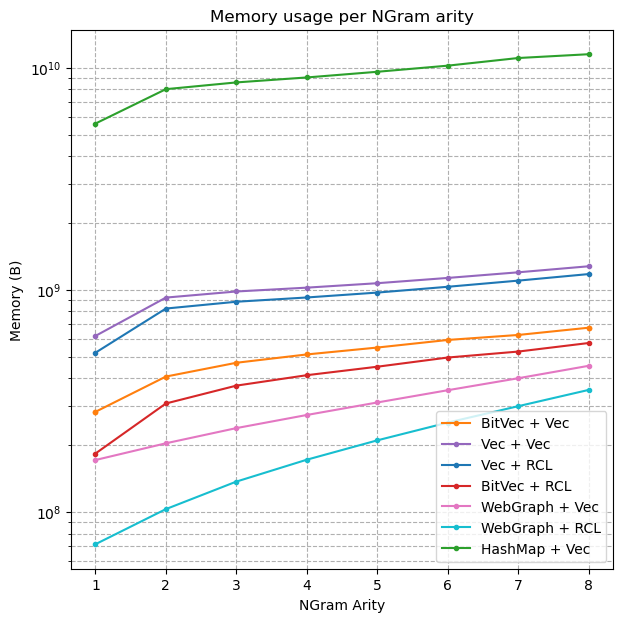

In [25]:
import matplotlib.pyplot as plt

colors = {
    'BitVec + RCL': "tab:red",
    'BitVec + Vec': "tab:orange",
    'HashMap + Vec': "tab:green",
    'Vec + RCL': "tab:blue",
    'Vec + Vec': "tab:purple",
    'WebGraph + RCL': "tab:cyan",
    'WebGraph + Vec': "tab:pink",
}

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for data_structure in df["Data structure"].unique():
    data = df[df["Data structure"] == data_structure]
    color = colors[data_structure]
    ax.plot(data["Arity"], data["Memory (B)"], label=data_structure, color=color, marker=".")

ax.set_xlabel("NGram Arity")
ax.set_ylabel("Memory (B)")
ax.set_title("Memory usage per NGram arity")
ax.set_yscale("log")
ax.grid(True, which="both", ls="--")
ax.legend()